# Washington State:Kings County:Houses:SGD Test
#### bdanalytics

In [166]:
print(format(Sys.time(), "(%a) %b %d, %Y"))

[1] "(Tue) Feb 09, 2016"


In [167]:
require(doMC)
glbCores <- 6 # of cores on machine - 2
registerDoMC(glbCores)

#require(Cairo)
#require(dplyr)
#require(ggplot2)
#require(jpeg)
#require(reshape2)
source("~/Dropbox/datascience/R/mydsutils.R")
source("~/Dropbox/datascience/R/myplot.R")

## Analytics Specs

In [168]:
glbObsTrnFile <- list(name = "kc_house_train_data.csv")
glbObsNewFile <- list(name = "kc_house_test_data.csv")
glb_rsp_var_raw <- "price"
glb_rsp_var <- glb_rsp_var_raw
glbObsTrnPartitionSeed <- 123

glbFeats <- c('sqft_living', 'sqft_living15')

## Import Data

In [169]:
glbObsTrn <- myimport_data(specs = glbObsTrnFile, comment = "glbObsTrn", 
                           force_header = TRUE)

[1] "Reading file ./data/kc_house_train_data.csv..."
[1] "dimensions of data in ./data/kc_house_train_data.csv: 17,384 rows x 21 cols"
          id            date   price bedrooms bathrooms sqft_living sqft_lot
1 7129300520 20141013T000000  221900        3      1.00        1180     5650
2 6414100192 20141209T000000  538000        3      2.25        2570     7242
3 5631500400 20150225T000000  180000        2      1.00         770    10000
4 2487200875 20141209T000000  604000        4      3.00        1960     5000
5 1954400510 20150218T000000  510000        3      2.00        1680     8080
6 7237550310 20140512T000000 1225000        4      4.50        5420   101930
  floors waterfront view condition grade sqft_above sqft_basement yr_built
1      1          0    0         3     7       1180             0     1955
2      2          0    0         3     7       2170           400     1951
3      1          0    0         3     6        770             0     1933
4      1          0    0  

Warning message:
In myprint_str_df(df): [list output truncated]

In [170]:
glbObsNew <- myimport_data(specs = glbObsNewFile, comment = "glbObsNew", 
                           force_header = TRUE)

[1] "Reading file ./data/kc_house_test_data.csv..."
[1] "dimensions of data in ./data/kc_house_test_data.csv: 4,229 rows x 21 cols"
          id            date  price bedrooms bathrooms sqft_living sqft_lot
1  114101516 20140528T000000 310000        3       1.0        1430    19901
2 9297300055 20150124T000000 650000        4       3.0        2950     5000
3 1202000200 20141103T000000 233000        3       2.0        1710     4697
4 8562750320 20141110T000000 580500        3       2.5        2320     3980
5 7589200193 20141110T000000 535000        3       1.0        1090     3000
6 2078500320 20140620T000000 605000        4       2.5        2620     7553
  floors waterfront view condition grade sqft_above sqft_basement yr_built
1    1.5          0    0         4     7       1430             0     1927
2    2.0          0    3         3     9       1980           970     1979
3    1.5          0    0         5     6       1710             0     1941
4    2.0          0    0         3  

Warning message:
In myprint_str_df(df): [list output truncated]

## Partition data

In [191]:
set.seed(glbObsTrnPartitionSeed)
OOB_size <- nrow(glbObsNew) * 1.1
print(sprintf("Fit vs. OOB split ratio:%0.4f", 
              1 - (OOB_size * 1.0 / nrow(glbObsTrn))))

require(caTools)
split <- sample.split(glbObsTrn[, glb_rsp_var_raw], SplitRatio = OOB_size)
print(sum(split))
glbObsOOB <- glbObsTrn[ split, ]            
glbObsFit <- glbObsTrn[!split, ]
print(sprintf("glbObsFit:")); print(dim(glbObsFit))
print(sprintf("glbObsOOB:")); print(dim(glbObsOOB))

[1] "Fit vs. OOB split ratio:0.7324"
[1] 4652
[1] "glbObsFit:"
[1] 12732    21
[1] "glbObsOOB:"
[1] 4652   21


In [192]:
print(OOB_size)
print(OOB_size * 1.0 / nrow(glbObsTrn))

[1] 4651.9
[1] 0.2675966


## Fit models

In [193]:
weightsZero <- rep(0, 1 + length(feats))
print(sprintf("weightsZero:"))
print(weightsZero)

[1] "weightsZero:"
[1] 0 0 0


In [194]:
#print(class(weightsZero))

In [195]:
predictOutput <- function(obsDf, feats, weights) {
    featMtrx <- cbind(matrix(rep(1.0, nrow(obsDf)), nrow = nrow(obsDf)),
                      as.matrix(obsDf[, feats]))
    #print(class(featMtrx))
    return(featMtrx %*% weights)
}

print(predictOutput(glbObsTrn, 'sqft_living', c(1.0, 1.0))[1]) # should be 1181.0
print(predictOutput(glbObsTrn, 'sqft_living', c(1.0, 1.0))[2]) # should be 2571.0

print(predictOutput(glbObsTrn, 'sqft_living', c(10.0, 2.0))[1]) # should be 2370.0
print(predictOutput(glbObsTrn, 'sqft_living', c(10.0, 2.0))[2]) # should be 5150.0

[1] 1181
[1] 2571
[1] 2370
[1] 5150


In [224]:
ridgeRegressionLossFn <- function(obsDf, feats, weights, l2Penalty) {
    return(sum((predictOutput(obsDf, feats, weights) - obsDf[, glb_rsp_var]) 
               ^ 2) + 
           l2Penalty * sum(weights ^ 2)
          )
}

ridgeRegressionLossGradientFn <- function(obsDf, feats, weights, l2Penalty, 
                                          featIx, isIntercept) {
#     print(sprintf(
#         "ridgeRegressionLossGradientFn: nrow(obsDf):%d; l2Penalty:%0.4f; featIx:%d; isIntercept:%s",
#                       nrow(obsDf), l2Penalty, featIx, isIntercept))
#     print(sprintf(
#         "ridgeRegressionLossGradientFn: weights:"))
#     print(weights)

    if (!isIntercept) {
        featX <- as.matrix(obsDf[, feats[featIx-1]])
    } else featX <- matrix(rep(1, nrow(obsDf)), nrow = nrow(obsDf))
    
    gradient <- 2 * 
                sum((predictOutput(obsDf, feats, weights) - 
                     obsDf[, glb_rsp_var]) *
                    featX)
    if (!isIntercept)
        gradient <- gradient + 2 * l2Penalty * weights[featIx]
        
#     print(sprintf(
#         "ridgeRegressionLossGradientFn: featIx:%d; gradient:%0.4e",
#                   featIx, gradient))
    return(gradient)
}

example_weights = c(1.0, 10.0)
example_predictions = predictOutput(glbObsTrn, 'sqft_living', example_weights)                
example_errors = example_predictions - glbObsTrn[, glb_rsp_var]        

# next two lines should print the same values
print(sum(example_errors * glbObsTrn[, 'sqft_living'])*2+20)
# print(example_errors[1:5])
# print(glbObsTrn[1:5, 'sqft_living'])
# print((example_errors * glbObsTrn[, 'sqft_living'])[1:5])
print(ridgeRegressionLossGradientFn(glbObsTrn, 'sqft_living', 
                                    example_weights, 
                                    l2Penalty = 1, featIx = 2, FALSE))        
        
# next two lines should print the same values
print('')
print(sum(example_errors)*2)
#print(example_errors[1:5])
print(ridgeRegressionLossGradientFn(glbObsTrn, 'sqft_living', 
                                    example_weights, 
                                    l2Penalty = 1, featIx = 1, TRUE))                

[1] -4.553289e+13
[1] -4.553289e+13
[1] ""
[1] -18029479492
[1] -18029479492


In [228]:
optimizeGradientDescent <- function(obsDf, feats, weightsInitial, 
                                    stepSize, l2Penalty, 
                                    lossFn, lossGradientFn, 
                                    maxIterations = 100, verbose = FALSE) {
    
    print(" ")
    print(sprintf("optimzeGradientDescent:")) 
    weights <- weightsInitial
    loss <- lossFn(obsDf, feats, weights, l2Penalty)    
    
    #while not reached maximum number of iterations:
    iterResults = data.frame(iterNum = 1:maxIterations)
    for (iterNum in 1:maxIterations) {
        if (verbose && 
            ((iterNum %% (maxIterations / 10) == 1) ||
             (iterNum <=10)))
            print(sprintf("  iteration: %d; loss:%0.4e", iterNum, loss))
            
        # loop over each weight            
        for (i in 1:length(weights)) {
            # compute the derivative for weight[i].
            #  when i=1, you are computing the derivative of the constant!
            gradient <- 
                lossGradientFn(obsDf, feats, weights, l2Penalty, 
                               i, (i == 1))
            
            # subtract the stepSize times the gradient from the 
            #   current weight
            weights[i] = weights[i] - stepSize * gradient
        }    
    
        loss <- lossFn(obsDf, feats, weights, l2Penalty)
        iterResults[iterNum, "loss"] <- loss   
    }    

    # Display results at end of iterations
    #myprint_df(iterResults)
    if (verbose)    
        print(myplot_line(iterResults, "iterNum", "loss"))
    return(weights)
}

[1] " "
[1] "optimzeGradientDescent:"
[1] "  iteration: 1; loss:4.7742e+15"
[1] "  iteration: 2; loss:3.1838e+15"
[1] "  iteration: 3; loss:2.2142e+15"
[1] "  iteration: 4; loss:1.6231e+15"
[1] "  iteration: 5; loss:1.2626e+15"
[1] "  iteration: 6; loss:1.0427e+15"
[1] "  iteration: 7; loss:9.0862e+14"
[1] "  iteration: 8; loss:8.2678e+14"
[1] "  iteration: 9; loss:7.7681e+14"
[1] "  iteration: 10; loss:7.4628e+14"
[1] "  iteration: 11; loss:7.2761e+14"
[1] "  iteration: 21; loss:6.9775e+14"
[1] "  iteration: 31; loss:6.9677e+14"
[1] "  iteration: 41; loss:6.9610e+14"
[1] "  iteration: 51; loss:6.9548e+14"
[1] "  iteration: 61; loss:6.9491e+14"
[1] "  iteration: 71; loss:6.9440e+14"
[1] "  iteration: 81; loss:6.9392e+14"
[1] "  iteration: 91; loss:6.9348e+14"
[1] "weightsL2Zero:"
[1]   0.04050541 162.70856430  99.68639470


ERROR: Error in file(con, "rb"): cannot open the connection


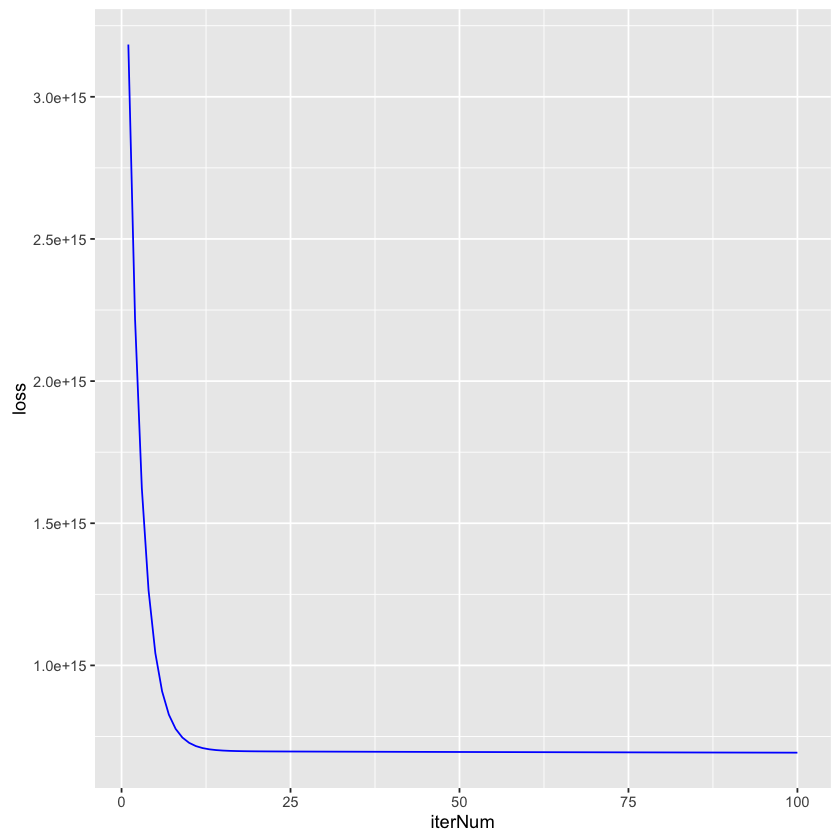

In [229]:
stepSize <- 1e-12; l2Penalty <- 0.0; maxIterations = 100
weightsL2Zero <- 
    optimizeGradientDescent(glbObsFit, glbFeats, weightsZero, 
                            stepSize, l2Penalty, 
                    ridgeRegressionLossFn, ridgeRegressionLossGradientFn, 
                            maxIterations, verbose = TRUE)
print(sprintf('weightsL2Zero:')) 
print(weightsL2Zero)

[1] " "
[1] "optimzeGradientDescent:"
[1] "  iteration: 1; loss:4.7742e+15"
[1] "  iteration: 2; loss:3.2007e+15"
[1] "  iteration: 3; loss:2.2873e+15"
[1] "  iteration: 4; loss:1.7570e+15"
[1] "  iteration: 5; loss:1.4492e+15"
[1] "  iteration: 6; loss:1.2705e+15"
[1] "  iteration: 7; loss:1.1667e+15"
[1] "  iteration: 8; loss:1.1065e+15"
[1] "  iteration: 9; loss:1.0715e+15"
[1] "  iteration: 10; loss:1.0512e+15"
[1] "  iteration: 11; loss:1.0394e+15"
[1] "  iteration: 21; loss:1.0232e+15"
[1] "  iteration: 31; loss:1.0231e+15"
[1] "  iteration: 41; loss:1.0231e+15"
[1] "  iteration: 51; loss:1.0231e+15"
[1] "  iteration: 61; loss:1.0231e+15"
[1] "  iteration: 71; loss:1.0231e+15"
[1] "  iteration: 81; loss:1.0231e+15"
[1] "  iteration: 91; loss:1.0231e+15"
[1] "weightsL2Hgh:"
[1]   0.1365188 135.8948979 106.8612538


ERROR: Error in file(con, "rb"): cannot open the connection


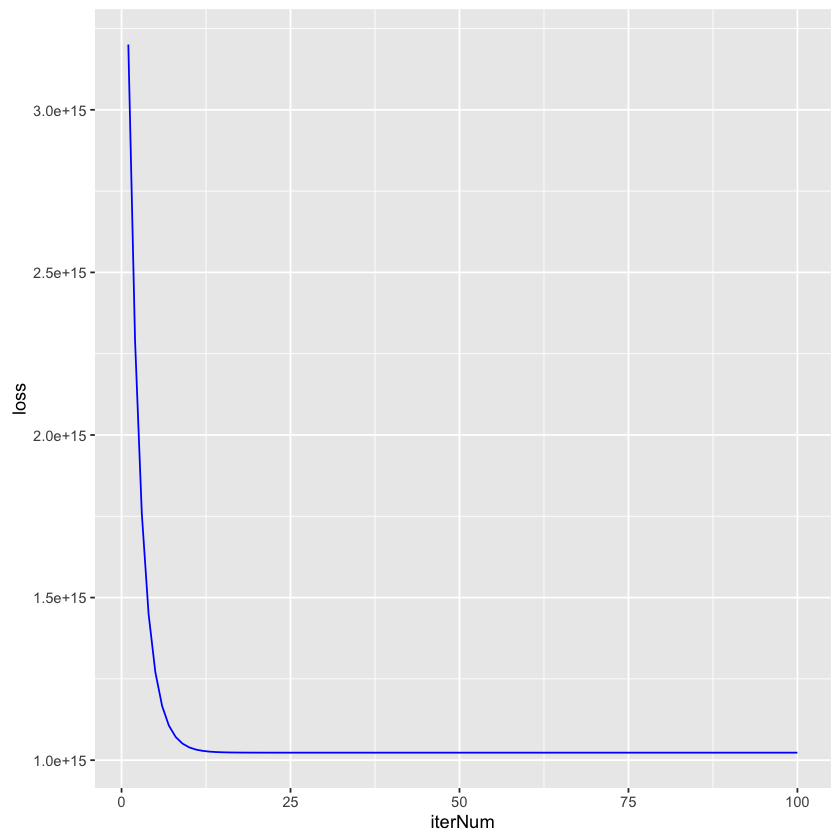

In [230]:
stepSize <- 1e-12; l2Penalty <- 1e10; maxIterations = 100
weightsL2Hgh <- 
    optimizeGradientDescent(glbObsFit, glbFeats, weightsZero, 
                            stepSize, l2Penalty, 
                    ridgeRegressionLossFn, ridgeRegressionLossGradientFn, 
                            maxIterations, verbose = TRUE)
print(sprintf('weightsL2Hgh:')) 
print(weightsL2Hgh)

### Find best model parameters

In [ ]:
maxIterations = 100
stepSize <- 1e-12; l2Penalty <- 1e10; 
weightsL2Hgh <- 
    optimizeGradientDescent(glbObsFit, glbFeats, weightsZero, 
                            stepSize, l2Penalty, 
                    ridgeRegressionLossFn, ridgeRegressionLossGradientFn, 
                            maxIterations, verbose = TRUE)
print(sprintf('weightsL2Hgh:')) 
print(weightsL2Hgh)

## Predict New data

In [222]:
getObsNewRSS <- function(obsDf, feats, weights) {
    return(sum((obsDf[, glb_rsp_var] - 
                predictOutput(obsDf, feats, weights)) ^ 2))
}    

In [223]:
print(" ")
print(sprintf("weightsZero:")) 
print(weightsZero)
print(sprintf("  glbObsNew RSS: %.4e", 
              getObsNewRSS(glbObsNew, glbFeats, weightsZero)))

print(" ")
print(sprintf('weightsL2Zero:')) 
print(weightsL2Zero)
print(sprintf('  glbObsNew RSS: %.4e', 
              getObsNewRSS(glbObsNew, glbFeats, weightsL2Zero)))

[1] " "
[1] "weightsZero:"
[1] 0 0 0
[1] "  glbObsNew RSS: 1.7843e+15"
[1] " "
[1] "weightsL2Zero:"
[1]   0.04050541 162.70856430  99.68639470
[1] "  glbObsNew RSS: 2.8102e+14"


In [181]:
print(sprintf("glbObsNew Obs 1 %s:%0.4f", 
              glb_rsp_var, glbObsNew[1, glb_rsp_var]))

print(" ")
print(sprintf("  weightsZero   %s prediction:%0.4f; error.abs:%0.4f", 
              glb_rsp_var, 
              prediction <- predictOutput(glbObsNew[1, ], weightsZero  ), 
              abs(prediction - glbObsNew[1, glb_rsp_var])))

print(" ")
print(sprintf("  weightsL2Zero %s prediction:%0.4f; error.abs:%0.4f", 
              glb_rsp_var, 
              prediction <- predictOutput(glbObsNew[1, ], weightsL2Zero), 
              abs(prediction - glbObsNew[1, glb_rsp_var])))

[1] "glbObsNew Obs 1 price:310000.0000"
[1] " "


ERROR: Error in predictOutput(glbObsNew[1, ], weightsZero): argument "weights" is missing, with no default


[1] " "


ERROR: Error in predictOutput(glbObsNew[1, ], weightsL2Zero): argument "weights" is missing, with no default


In [182]:
print(sessionInfo())

R version 3.2.2 (2015-08-14)
Platform: x86_64-apple-darwin15.0.0 (64-bit)
Running under: OS X 10.11.3 (El Capitan)

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] caTools_1.17.1  doBy_4.5-14     survival_2.38-3 caret_6.0-64   
[5] ggplot2_2.0.0   lattice_0.20-33 doMC_1.3.4      iterators_1.0.8
[9] foreach_1.4.3  

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.3        nloptr_1.0.4       plyr_1.8.3         bitops_1.0-6      
 [5] base64enc_0.1-3    tools_3.2.2        digest_0.6.9       lme4_1.1-10       
 [9] uuid_0.1-2         jsonlite_0.9.19    evaluate_0.8       gtable_0.1.2      
[13] nlme_3.1-124       mgcv_1.8-11        Matrix_1.2-3       IRdisplay_0.3     
[17] IRkernel_0.5       SparseM_1.7        rzmq_0.7.7         repr_0.4          
[21] stringr_1.0.0      MatrixModels_0.4-1 stats4_3.2.2       grid